In [177]:
import os
import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

In [107]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)

In [9]:
TRAIN_DATA_PATH = "./cicddos_data/out/train.csv"
TEST_DATA_PATH = "./cicddos_data/out/test.csv"

In [140]:
def get_req_cols():
    with open("./pkls/req_cols.pkl", "rb") as f:
        return pkl.load(f)

In [75]:
train_df = pd.read_csv(TRAIN_DATA_PATH, low_memory=False)

In [76]:
train_df_copy = train_df.copy()

In [21]:
attack_names = train_df["Label"].value_counts().index
sizes = train_df["Label"].value_counts().values
explode = [0] * len(sizes)
explode[1] = 0.1
wp = { 'linewidth' : 1, 'edgecolor' : "green" }

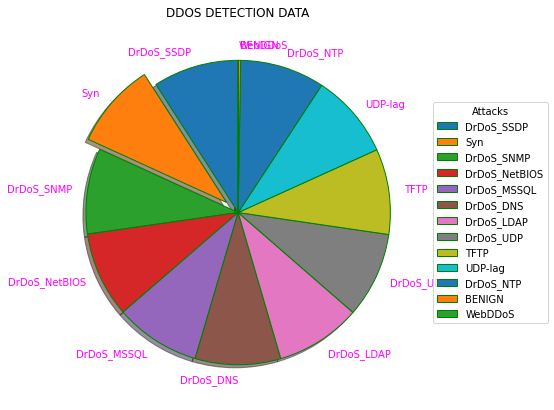

In [26]:
fig, sp = plt.subplots(figsize =(10, 7))
wedges, texts = sp.pie(sizes,
                                  explode = explode,
                                  labels = attack_names,
                                  shadow = True,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="magenta"))
sp.legend(wedges, attack_names,
          title ="Attacks",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
sp.set_title("DDOS DETECTION DATA")
plt.show()

## Data Preprocessing

In [124]:
class FilterFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        columns_to_be_removed = ['Flow ID', 'Source IP', 
                                 'Source Port', 'Destination IP', 
                                 'Destination Port', 'Timestamp', 
                                 'SimillarHTTP', 'Flow Bytes/s', 'Flow Packets/s']
        for col_name in X.columns:
            if "Bwd " in col_name:
                columns_to_be_removed.append(col_name)
        
        return X.drop(columns_to_be_removed, axis=1, inplace=False)

In [165]:
class SeparateLabelsFromX(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self, X):
        return X.drop(["Label", "attack_type", "is_attack"], axis=1, inplace=False)

In [166]:
us_pipeline = Pipeline([
    ("label_seperator", SeparateLabelsFromX()),
    ("feature_filter", FilterFeatures()),
    ("std_scaler", StandardScaler()),
    ("normalizer", Normalizer()),
    ("imputer", SimpleImputer(strategy="median"))
])

In [48]:
feature_filter = FilterFeatures()

In [49]:
filtered_train_df = feature_filter.fit_transform(train_df)

In [ ]:
label_separater = SeparateLabelsFromX()
label_separater.fit_transform(filtered_train_df).info()

In [167]:
preprocessed_train_data = us_pipeline.fit_transform(train_df)
preped_cols = get_req_cols()
preped_cols.remove("Label")
preped_cols.remove("attack_type")
preprocessed_train_data = pd.DataFrame(preprocessed_train_data, columns=preped_cols)

In [151]:
preprocessed_train_data.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Length,Fwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
0,0.455038,-0.139997,-0.017764,-0.030226,-0.216228,-0.472542,-0.513581,-0.499461,0.954535,-0.161761,-0.159940,-0.156660,-0.004401,-0.139887,-0.162822,-0.159822,-0.156491,-0.003980,-0.018231,0.0,0.051056,-1.207735,-0.513511,-0.470897,-0.506172,0.738964,-0.001260,0.0,-0.005916,-0.018231,0.0,-0.452677,-0.037728,-0.029563,0.0,-0.126727,-0.562315,-0.499461,0.051056,0.0,0.0,0.0,-0.017764,-0.216228,-0.408375,-0.016662,-0.149074,0.196210,-0.016956,-0.019426,-0.021212,-0.010309,-0.145099,-0.107095,-0.143982,-0.138355,0.051391
1,0.455038,-0.139713,-0.017764,-0.030226,-0.216228,-0.472542,-0.513581,-0.499461,0.954535,-0.160906,-0.158967,-0.155921,-0.004316,-0.139604,-0.162022,-0.158875,-0.155752,-0.003898,-0.018231,0.0,0.051056,-1.207736,-0.513511,-0.470897,-0.506172,0.738964,-0.001260,0.0,-0.005916,-0.018231,0.0,-0.452677,-0.037728,-0.029563,0.0,-0.126727,-0.562315,-0.499461,0.051056,0.0,0.0,0.0,-0.017764,-0.216228,-0.408375,-0.016662,-0.149074,0.196210,-0.016956,-0.019426,-0.021212,-0.010309,-0.145099,-0.107095,-0.143982,-0.138355,0.051391
2,0.455038,-0.151205,-0.024648,-0.030226,-0.250922,-0.227728,-0.199959,-0.219089,-0.292345,-0.195555,-0.198443,-0.185864,-0.004230,-0.151096,-0.194463,-0.197244,-0.185698,-0.003816,-0.018231,0.0,0.051056,-0.108063,-0.199866,-0.227577,-0.218584,-0.242224,-0.013902,0.0,-0.005916,-0.018231,0.0,-0.452677,-0.037728,-0.029563,0.0,-0.126727,-0.174265,-0.219089,0.051056,0.0,0.0,0.0,-0.024648,-0.250922,-0.408375,-0.016662,-0.225335,0.196210,-0.016956,-0.019426,-0.021212,-0.010309,-0.145099,-0.107095,-0.143982,-0.138355,0.051391
3,0.455038,-0.151200,-0.024648,-0.030226,-0.268182,-0.412740,-0.382598,-0.403520,-0.292345,-0.195512,-0.198443,-0.185852,-0.000376,-0.151091,-0.194422,-0.197244,-0.185686,-0.000130,-0.018231,0.0,0.051056,-1.160981,-0.382518,-0.411460,-0.402983,-0.242224,-0.013902,0.0,-0.005916,-0.018231,0.0,-0.452677,-0.037728,-0.029563,0.0,-0.126727,-0.355477,-0.403520,0.051056,0.0,0.0,0.0,-0.024648,-0.268182,-0.408375,-0.016662,-0.225335,0.196210,-0.016956,-0.019426,-0.021212,-0.010309,-0.145099,-0.107095,-0.143982,-0.138355,0.051391
4,0.455038,-0.151205,-0.024648,-0.030226,-0.271320,-0.446379,-0.415805,-0.437053,-0.292345,-0.195557,-0.198443,-0.185865,-0.004401,-0.151096,-0.194464,-0.197244,-0.185699,-0.003980,-0.018231,0.0,-0.776661,-1.207777,-0.415728,-0.444893,-0.436510,-0.242224,-0.013902,0.0,-0.005916,-0.018231,0.0,-0.452677,-0.037728,-0.029563,0.0,-0.126727,-0.388424,-0.437053,-0.776661,0.0,0.0,0.0,-0.024648,-0.271320,-0.408375,-0.016662,-0.225335,-5.096216,-0.016956,-0.019426,-0.021212,-0.010309,-0.145099,-0.107095,-0.143982,-0.138355,0.051391


In [136]:
columns_to_be_removed = ['Flow ID', 'Source IP', 
                                 'Source Port', 'Destination IP', 
                                 'Destination Port', 'Timestamp', 
                                 'SimillarHTTP', 'Flow Bytes/s', 'Flow Packets/s']
for col_name in train_df.columns:
    if "Bwd " in col_name:
        columns_to_be_removed.append(col_name)

req_columns = train_df.columns.tolist()
for col_name in columns_to_be_removed:
    req_columns.remove(col_name)

In [153]:
train_df["Label"].value_counts()

DrDoS_SSDP       199955
Syn              199948
DrDoS_SNMP       199944
DrDoS_NetBIOS    199904
DrDoS_MSSQL      199897
DrDoS_DNS        199868
DrDoS_LDAP       199855
DrDoS_UDP        199822
TFTP             199730
UDP-lag          197778
DrDoS_NTP        197597
BENIGN             5471
WebDDoS             231
Name: Label, dtype: int64

In [154]:
train_df["is_attack"] = train_df["Label"] != "BENIGN"

In [155]:
train_df["is_attack"].value_counts()

True     2194529
False       5471
Name: is_attack, dtype: int64

## Unsupervised approaches

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


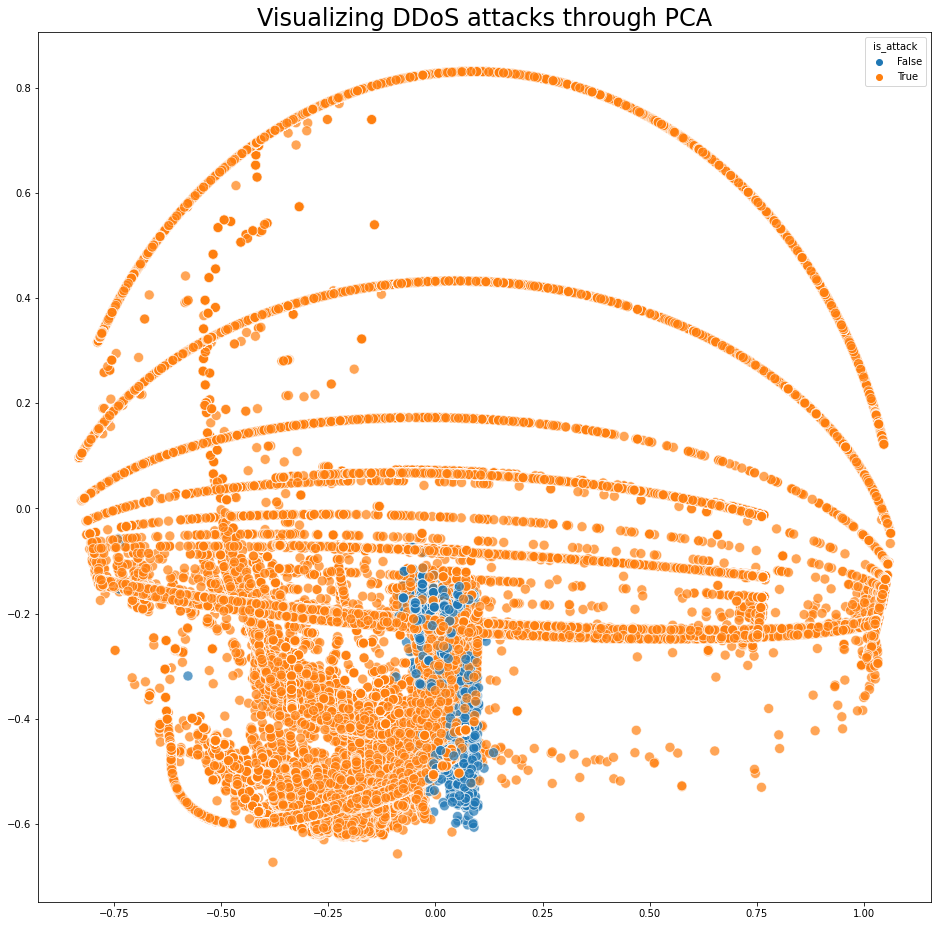

In [169]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(preprocessed_train_data)
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(principalComponents[:, 0], principalComponents[:, 1], s= 100, hue=train_df['is_attack'], cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through PCA', fontsize=24);

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Visualizing DDoS attacks through t-SNE')

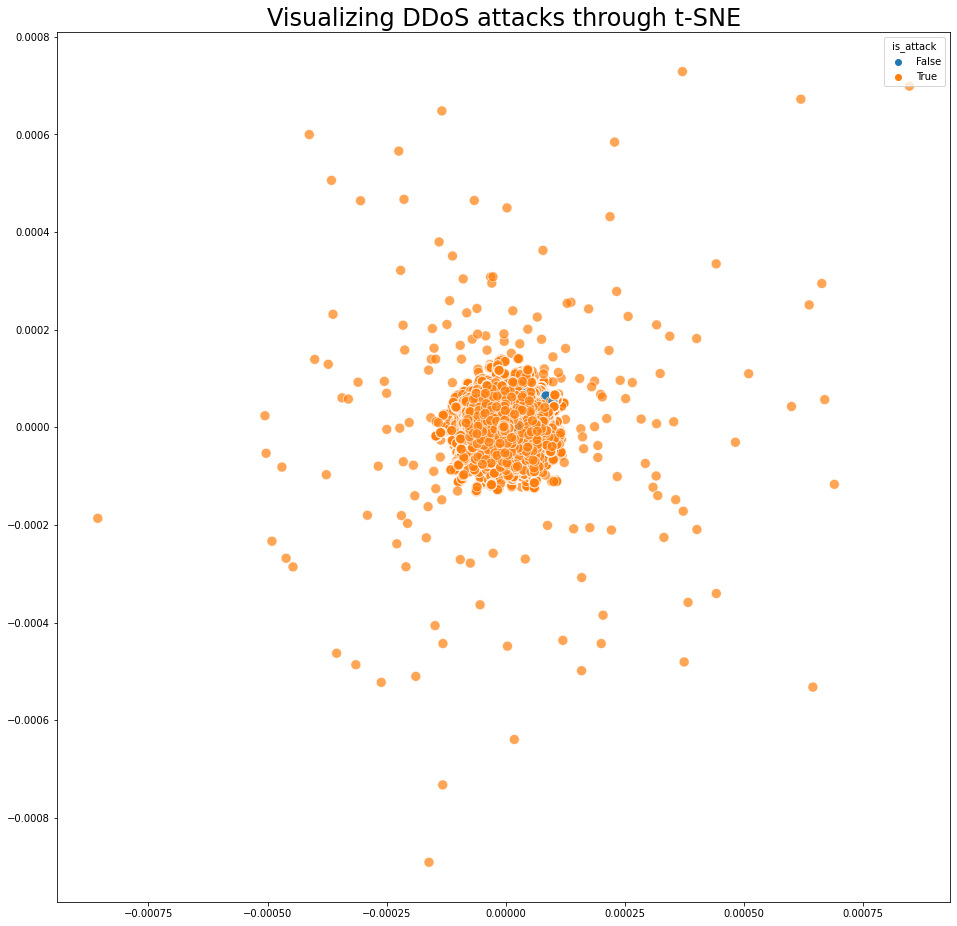

In [174]:
pca_ = PCA(n_components=2) 
principalComponents = pca_.fit_transform(preprocessed_train_data)

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Visualizing DDoS attacks through t-SNE')

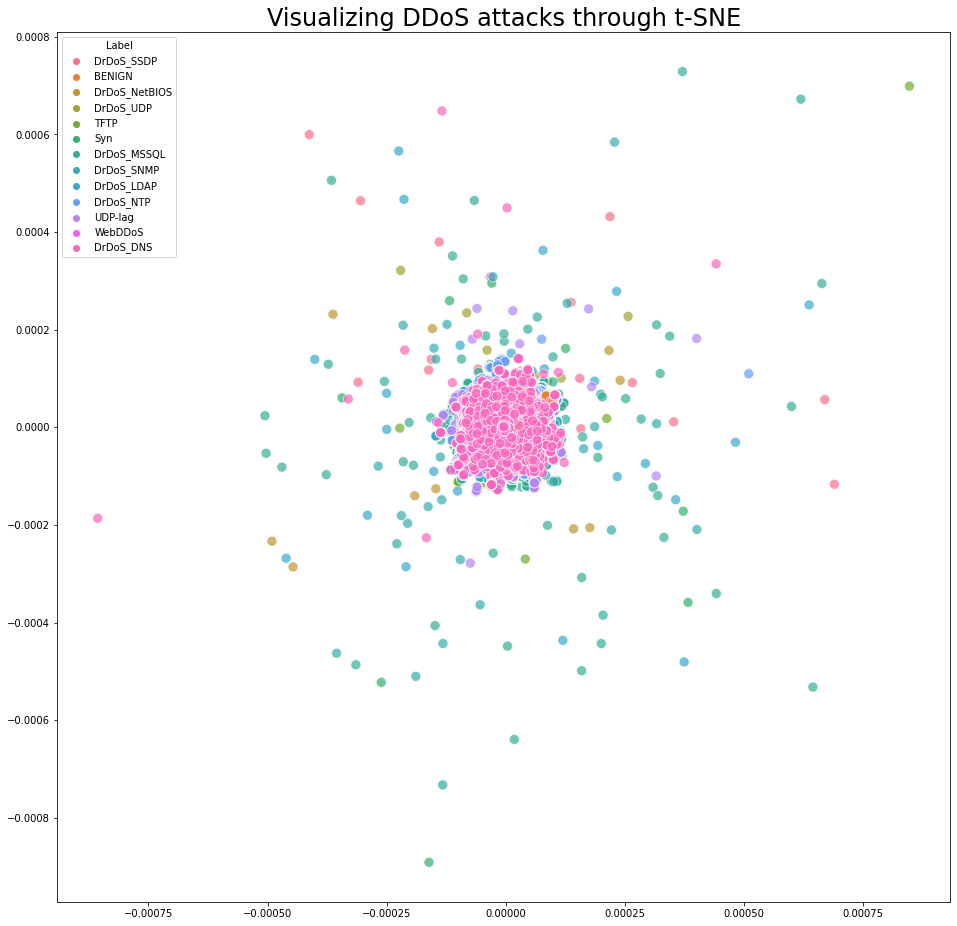

In [180]:
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(tsne_[:, 0], tsne_[:, 1], s= 100, hue=train_df['Label'], cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through t-SNE', fontsize=24)

In [181]:
# Agglo = AgglomerativeClustering(n_clusters=8)
# Agglo.fit(principalComponents)
# plt.figure(figsize=(20,11))
# plt.scatter(tsne_[:, 0],tsne_[:, 1], c=Agglo.labels_,edgecolors='black')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(8))
# plt.title('Visualizing DDoS attacks after Agglomerative Clustering', fontsize=24);
# plt.show()

/home/ubuntu/Envs/ddos/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


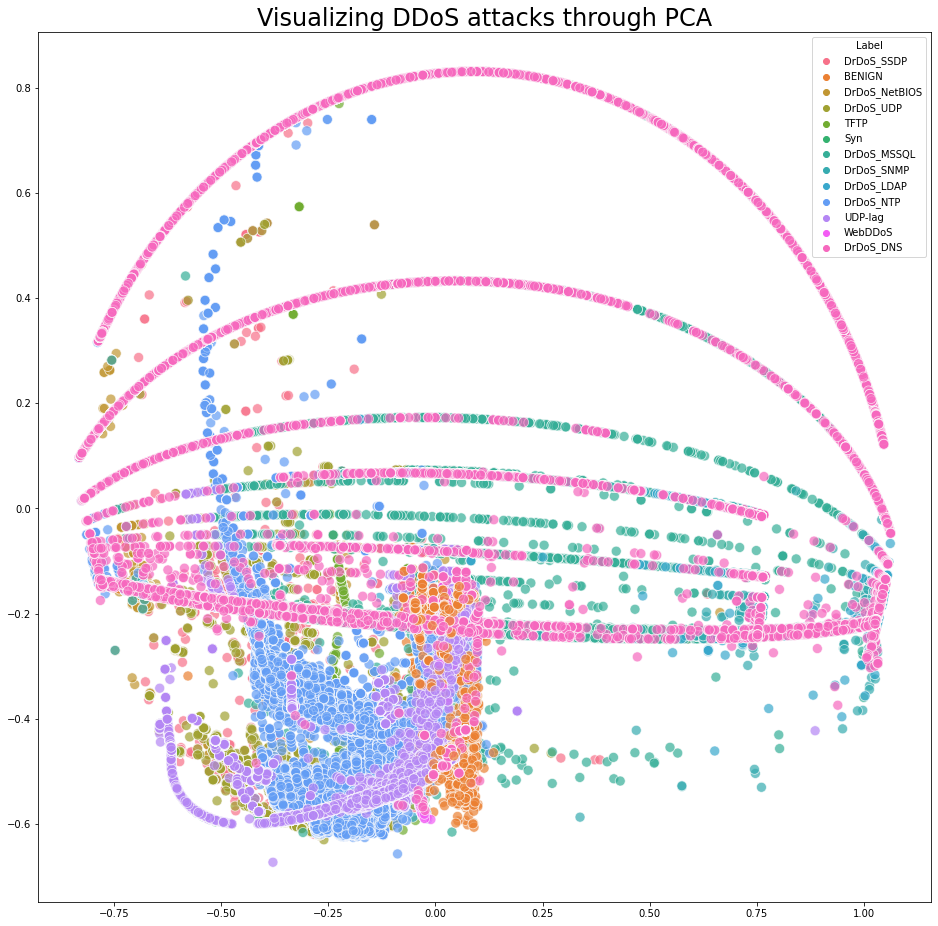

In [182]:
plt.figure(figsize=(16,16))
g1 = sns.scatterplot(principalComponents[:, 0], principalComponents[:, 1], s= 100, hue=train_df['Label'], cmap='Spectral',alpha=0.7)
plt.title('Visualizing DDoS attacks through PCA', fontsize=24);